In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from FileFinder import FileFinder as ff

path = ff.get_path('constituents.csv')

#path = "Users\rhys\Desktop\740\Reference_Data\constituents.csv"

path


'C:\\Users\\Rhys Logan\\OneDrive\\Desktop\\740\\Reference_Data\\constituents.csv'

In [5]:

sp500_Data = pd.read_csv(path)

# .sample(100)
symbols = sp500_Data['Symbol'].sample(30).to_list()
#sector = sp500_Data['Sector'].to_list()


def sort_tick_frame(calls_df, puts_df, exp, tick):
    
    now = datetime.datetime.now()
    
    df = pd.concat([calls_df, puts_df], axis = 0)
    df['mark'] = (df['bid'] + df['ask']) / 2 
    df['expirationDate'] = exp
    df['days_to_expiration'] = [(pd.to_datetime(i) - now).days for i in df['expirationDate']]
    df['ticker'] = tick
    #df['sector'] = sector[num]
    #df['CALL'] = df['contractSymbol'].str[4:].apply(lambda x: "C" in x)
    df = df.drop(columns = ['contractSize', 'currency', 'lastTradeDate'])
    
    return df

In [6]:


options = pd.DataFrame()

length = len(symbols)
count = 1
for num, tick in enumerate(symbols):
    
    print(f"{count} of {length}")
    count += 1
    
    if '.' in tick:
        tick.replace('.', '-')
    
    ticker = yf.Ticker(tick)
    exprys = ticker.options
    
    for exp in exprys:
        
        ticker_options = ticker.option_chain(exp)
        
        calls = ticker_options.calls
        calls['inTheMoney'] = calls['inTheMoney'].astype("int32")
        calls['CALL'] = 1
        puts = ticker_options.puts
        puts['inTheMoney'] = puts['inTheMoney'].astype("int32")
        puts['CALL'] = 0
        
        this_ticker = sort_tick_frame(ticker_options.calls, ticker_options.puts, exp, tick)
        options = pd.concat([options, this_ticker], axis = 0, ignore_index=True)

1 of 30
2 of 30
3 of 30
4 of 30
5 of 30
6 of 30
7 of 30
8 of 30
9 of 30
10 of 30
11 of 30
12 of 30
13 of 30
14 of 30
15 of 30
16 of 30
17 of 30
18 of 30
19 of 30
20 of 30
21 of 30
22 of 30
23 of 30
24 of 30
25 of 30
26 of 30
27 of 30
28 of 30
29 of 30
30 of 30


In [7]:

options_per_exp_date = {}
call_options_per_exp_date = {}

time_buckets = ['<1M', '1-3M', '3-6M', '6M-1Y', '1-2Y', '2+Y']

for exp in options.days_to_expiration.sort_values().unique():
    
    if exp <= 30:
        
        key = time_buckets[0]
        
    elif exp <= 90:
        key = time_buckets[1]
    
    elif exp <= 180:
        key = time_buckets[2]
    
    elif exp <= 365:
        key = time_buckets[3]
    
    elif exp <= 730:
        key = time_buckets[4]
    
    elif exp > 730:
        key = time_buckets[5]
        
    options_per_exp_date[key] = {}
    options_per_exp_date[key]['put'] = options.loc[ (options.days_to_expiration == exp) & (options.CALL == 0) & (options.inTheMoney == 1) ]['mark'].mean()
    options_per_exp_date[key]['call'] = options.loc[ (options.days_to_expiration == exp) & (options.CALL == 1) & (options.inTheMoney == 1) ]['mark'].mean()


<AxesSubplot:>

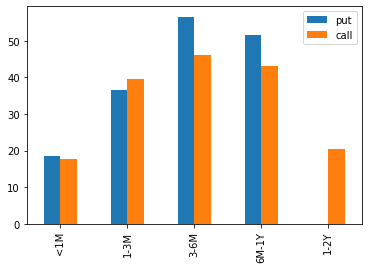

In [8]:


pd.DataFrame(options_per_exp_date).T.plot.bar()



In [30]:


#spy = yf.Ticker("SPY")

spy_price = yf.download("SPY", start = '2022-01-01', progress=False)['Close']

spy_price = spy_price[-1]

spy_price

381.239990234375

In [43]:

spy_options = pd.DataFrame()

spy = yf.Ticker("SPY")
exps = spy.options
opts = spy.option_chain()

for ex in exps:
    print(ex)
    ticker_options = spy.option_chain(ex)
    
    calls = ticker_options.calls
    calls['inTheMoney'] = calls['inTheMoney'].astype("int32")
    calls['CALL'] = 1
    puts = ticker_options.puts
    puts['inTheMoney'] = puts['inTheMoney'].astype("int32")
    puts['CALL'] = 0
    
    this_exp = sort_tick_frame(calls, puts, ex, 'SPY')
    
    this_exp['diff_from_strike'] = spy_price - this_exp['strike']
    
    spy_options = pd.concat([spy_options, this_exp], axis = 0, ignore_index=True)
    

2022-07-05
2022-07-06
2022-07-08
2022-07-11
2022-07-13
2022-07-15
2022-07-18
2022-07-20
2022-07-22
2022-07-25
2022-07-27
2022-07-29
2022-08-01
2022-08-03
2022-08-05
2022-08-08
2022-08-12
2022-08-19
2022-09-16
2022-09-30
2022-10-21
2022-11-18
2022-12-16
2022-12-30
2023-01-20
2023-03-17
2023-03-31
2023-06-16
2023-06-30
2023-09-15
2023-12-15
2024-01-19
2024-06-21
2024-12-20


In [44]:


spy_options



,contractSymbol,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,CALL,mark,expirationDate,days_to_expiration,ticker,diff_from_strike
0,SPY220705C00250000,250.0,126.47,130.72,131.19,126.47,NaN,4.0,0.0,0.000010,1,1,130.955,2022-07-05,0,SPY,131.23999
1,SPY220705C00295000,295.0,88.51,85.64,86.26,0.00,0.0,1.0,1.0,1.718751,1,1,85.950,2022-07-05,0,SPY,86.23999
2,SPY220705C00315000,315.0,72.67,65.64,66.27,0.00,0.0,1.0,1.0,1.375003,1,1,65.955,2022-07-05,0,SPY,66.23999
3,SPY220705C00324000,324.0,55.37,56.78,57.26,55.37,NaN,3.0,0.0,1.140629,1,1,57.020,2022-07-05,0,SPY,57.23999
4,SPY220705C00330000,330.0,60.83,50.65,51.27,0.00,0.0,1.0,14.0,1.062505,1,1,50.960,2022-07-05,0,SPY,51.23999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7549,SPY241220P00700000,700.0,313.01,316.73,326.54,0.00,0.0,7.0,122.0,0.275200,1,0,321.635,2024-12-20,899,SPY,-318.76001
7550,SPY241220P00705000,705.0,304.79,338.04,342.50,0.00,0.0,15.0,18.0,0.353080,1,0,340.270,2024-12-20,899,SPY,-323.76001
7551,SPY241220P00710000,710.0,335.55,324.93,334.93,0.00,0.0,1.0,0.0,0.265098,1,0,329.930,2024-12-20,899,SPY,-328.76001
7552,SPY241220P00715000,715.0,322.60,341.10,346.00,0.00,0.0,1.0,14.0,0.316215,1,0,343.550,2024-12-20,899,SPY,-333.76001


In [72]:
import plotly.express as px

spy_options_out_of_money_options = spy_options.loc[ (spy_options.inTheMoney == 0)]
spy_options_out_of_money_puts = spy_options.loc[ (spy_options.inTheMoney == 0) & (spy_options.CALL == 0) ]
spy_options_out_of_money_calls = spy_options.loc[ (spy_options.inTheMoney == 0) & (spy_options.CALL == 1) ]
spy_options_in_the_money_puts = spy_options.loc[ (spy_options.inTheMoney == 1) & (spy_options.CALL == 0) ]
spy_options_in_the_money_calls = spy_options.loc[ (spy_options.inTheMoney == 1) & (spy_options.CALL == 1) ]


px.scatter(spy_options_out_of_money_puts, x = 'days_to_expiration', y = 'mark', color = 'diff_from_strike', hover_data = ['strike'], title="Out the Money Puts")



In [71]:



px.scatter(spy_options_out_of_money_calls, x = 'days_to_expiration', y = 'mark', color = 'diff_from_strike', hover_data = ['strike'], title="Out the Money Calls")




In [74]:



px.scatter(spy_options_in_the_money_puts, x = 'days_to_expiration', y = 'mark', color = 'diff_from_strike', hover_data = ['strike'], title="In the Money Puts")




In [73]:


px.scatter(spy_options_in_the_money_calls, x = 'days_to_expiration', y = 'mark', color = 'diff_from_strike', hover_data = ['strike'], title="In the Money Calls")



<AxesSubplot:>

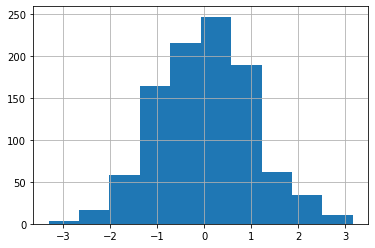

In [88]:



pd.Series(np.random.standard_normal(1000[])).hist()

